<a href="https://colab.research.google.com/github/Heisnotanimposter/ObjectDetection_with_Server/blob/main/PersonSpeedvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Aug 15 13:25:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q supervision ultralytics
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.0/869.0 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.6 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
import shutil
import os
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from ultralytics import YOLO
from collections import defaultdict, deque
from scipy.spatial import distance

In [5]:
# Person dataset
!mkdir -p /content/person_dataset
!curl -L "https://universe.roboflow.com/ds/JrT0ne1aM8?key=?" > /content/person_dataset/roboflow.zip
!unzip /content/person_dataset/roboflow.zip -d /content/person_dataset
!rm /content/person_dataset/roboflow.zip


Streaming output truncated to the last 5000 lines.
 extracting: /content/person_dataset/train/labels/FudanPed00035_png.rf.2928a6dadaed81ebaaefd8d8c1b1fbc3.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00035_png.rf.561f5fabdbbd41e65cacfcc73c52c22b.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00037_png.rf.2cbf629b6606e4ae6fcd9d3e06931348.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00037_png.rf.46a0cef9c05d83b1662c36c928055c6f.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00037_png.rf.9f91e445dac1f141005faae99a6c627e.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00038_png.rf.0853d95119f7aee013a8762123b146af.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00038_png.rf.a02242c6c972389ef045d6b62d8a1a0a.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00038_png.rf.aed4a8257c60fc915e17b4ca03eecf2b.txt  
 extracting: /content/person_dataset/train/labels/FudanPed00041_png.r

In [13]:
# Write the data.yaml file
!echo "" > /content/person_dataset/data.yaml
!echo "train: /content/person_dataset/train" >> /content/person_dataset/data.yaml
!echo "val: /content/person_dataset/valid" >> /content/person_dataset/data.yaml
!echo "test: /content/person_dataset/test" >> /content/person_dataset/data.yaml
!echo "" >> /content/person_dataset/data.yaml
!echo "nc: 1" >> /content/person_dataset/data.yaml
!echo "names: ['person']  # Names of the classes" >> /content/person_dataset/data.yaml
!echo "roboflow:">> /content/person_dataset/data.yaml
!echo "  workspace: leo-ueno">> /content/person_dataset/data.yaml
!echo "  project: people-detection-o4rdr">> /content/person_dataset/data.yaml
!echo "  version: 8">> /content/person_dataset/data.yaml
!echo "  license: Private">> /content/person_dataset/data.yaml
!echo "  url: https://universe.roboflow.com/leo-ueno/people-detection-o4rdr/dataset/8">> /content/person_dataset/data.yaml

## Imports

In [16]:
import cv2
import os
import shutil

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from collections import defaultdict, deque

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [24]:
# Paths for the video
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Team7dataset/Team7Shared/140sDayShinjuku.mp4"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/Team7dataset/Team7Shared/140sDayShinjuku.mp4"

# YOLO model settings
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8s.pt"
MODEL_RESOLUTION = 720

Transformed Crosswalk 1:


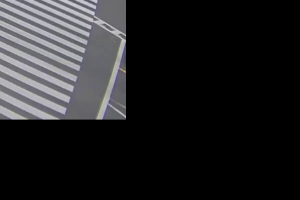

Crosswalk 1 transformed points:
[[          0           0]
 [        299           0]
 [        299         199]
 [          0         199]]
Transformed Crosswalk 2:


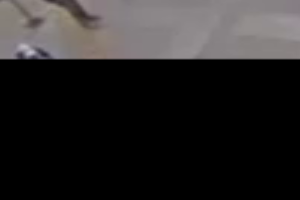

Crosswalk 2 transformed points:
[[          0           0]
 [        299           0]
 [        299         199]
 [          0         199]]
Transformed Crosswalk 3:


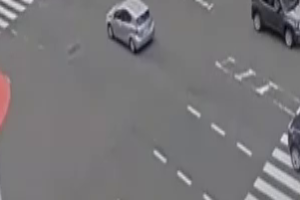

Crosswalk 3 transformed points:
[[ 2.8422e-14  5.6843e-14]
 [        299           0]
 [        299         199]
 [ 2.8422e-14         199]]
Transformed Crosswalk 4:


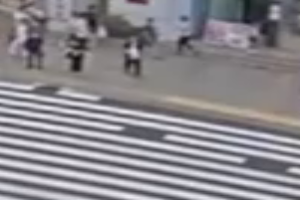

Crosswalk 4 transformed points:
[[ 2.2737e-13           0]
 [        299           0]
 [        299         199]
 [ 2.2737e-13         199]]


In [25]:
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

# Define multiple source areas for crosswalks
source_areas = [
    np.array([[600, 300], [1200, 300], [1200, 600], [600, 600]]),  # Crosswalk 1
    np.array([[0, 450], [100, 450], [100, 550], [0, 550]]), # Crosswalk 2
    np.array([[150, 150], [450, 150], [450, 250], [150, 250]]),   # Crosswalk 3
    np.array([[600, 100], [700, 100], [700, 200], [600, 200]]),   # Crosswalk 4
    #np.array([[150, 250], [450, 250], [450, 350], [150, 350]]),   # Crosswalk 5
]

# Define a single target area (rectangle) for the perspective transformation
TARGET_WIDTH = 300  # Adjust to your needs
TARGET_HEIGHT = 200  # Adjust to your needs

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

target_area = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
], dtype=np.float32)

# Assuming you have a 'frame' loaded, for example, from a video or image
#frame = cv2.imread(SOURCE_VIDEO_PATH)

# Process each crosswalk
for i, source in enumerate(source_areas):
    view_transformer = ViewTransformer(source=source, target=target_area)

    # Apply perspective transformation to the entire frame for the current crosswalk
    transformed_frame = cv2.warpPerspective(frame, view_transformer.m, (TARGET_WIDTH, TARGET_HEIGHT))

    # Display the transformed frame (only in Colab)
    from google.colab.patches import cv2_imshow
    print(f"Transformed Crosswalk {i+1}:")
    cv2_imshow(transformed_frame)

    # Example operation: print the transformed points
    print(f"Crosswalk {i+1} transformed points:")
    print(view_transformer.transform_points(source))


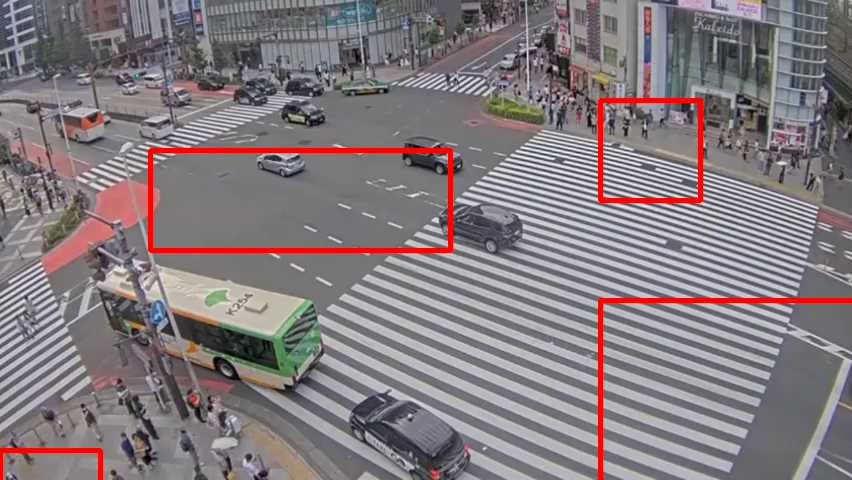

In [26]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
# Annotate the original frame with the polygon for the current source area
annotated_frame = frame.copy()
color = (0, 0, 255)  # RGB
for src in source_areas:
    cv2.polylines(annotated_frame, [src.astype(np.int32)], isClosed=True, color=color, thickness=4)

# Display the annotated frame
cv2_imshow(annotated_frame)

## Transform Perspective

In [27]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

AttributeError: 'str' object has no attribute 'astype'

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt") # load the model
results = model.train(data="/content/person_dataset/data.yaml", epochs=5, imgsz=480)
results = model("/content/drive/MyDrive/Team7dataset/140sDayShinjuku.mp4")

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_dynamic_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_dynamic_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/person_dataset/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /content/person_dataset/train/labels.cache... 15210 images, 1917 backgrounds, 0 corrupt: 100%|██████████| 15210/15210 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/person_dataset/train/images/000066_jpg.rf.7af12755c989607af4ff8faf8be1ed1b.jpg: 16 duplicate labels removed
train: WARNING ⚠️ /content/person_dataset/train/images/2007_002387_jpg.rf.b185b9383eb87d476665f67d98e93996.jpg: 13 duplicate labels removed
train: WARNING ⚠️ /content/person_dataset/train/images/2007_002845_jpg.rf.f86d7a1b7e9851bf8201be8dcaf3c8ec.jpg: 23 duplicate labels removed
train: WARNING ⚠️ /content/person_dataset/train/images/2007_003226_jpg.rf.f1f5326d95fecd08c5a9dfdad9259e28.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/person_dataset/train/images/2008_003526_jpg.rf.4a836fd57d560fc005eab941399b6500.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/person_dataset/train/images/2008_003598_jpg.rf.df9555297acad95b8d1833b8cb78e7fb.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/person_dataset/train/images/2008_003608_jpg.rf.11cb8904ac10f9f5fbaba7b3da1a5364.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/pe


val: Scanning /content/person_dataset/valid/labels.cache... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/person_dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.87G      1.465      1.267      1.261        120        480: 100%|██████████| 951/951 [02:42<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.06it/s]

                   all       1431      10660      0.641      0.469      0.498      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.86G      1.476      1.258      1.275         93        480: 100%|██████████| 951/951 [02:32<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:07<00:00,  5.94it/s]


                   all       1431      10660      0.669      0.485       0.51      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.71G      1.414      1.189      1.245        173        480:  91%|█████████ | 864/951 [02:16<00:13,  6.38it/s]

In [ ]:
# prompt: tensorboard

%load_ext tensorboard
%tensorboard --logdir runs/detect/train


In [ ]:
# Load the best model
model = YOLO("/content/runs/detect/train3/weights/best.pt")
!cp /content/runs/detect/train3/weights/best.pt /content/drive/MyDrive/Team7dataset/Team7Shared/
# Run validation on the model (using the validation data)
results = model.val()


In [ ]:
#model.train(data="/content/drive/MyDrive/Team7dataset/Team7Shared/data.yaml", epochs=32, imgsz=480, name="people_detection_model")

# Test the model on a new image
results = model.predict("/content/drive/MyDrive/Team7dataset/Team7Shared/140sDayShinjuku.mp4", imgsz=320, conf=0.5, iou=0.5, batch=16)

# Display results
#results.show()

# Save results
results.save("/content/drive/MyDrive/Team7dataset/DayShinjuku_result.mp4")
